In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import math
from scipy import stats
import geopandas as gpd
import sklearn
from sklearn import preprocessing 
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Owners DataFrame

In [3]:
#staff_xlsx = pd.ExcelFile('Owners.xlsx')
Owners = pd.read_csv('Owners_Final_Neighborhood.csv')

In [4]:
#create a dictionary to map the neighborhood names, to align
name_dict ={ 'Astoria/LIC':'Astoria/LIC', 'Bed-Stuy':'Bed-Stuy','Bed-Stuy/Bushwick':'Bed-Stuy/Bushwick',
            'Bed-Stuy/Bushwick/Williamsburg':'Williamsburg/Bushwick/Bed-Stuy','Bushwick':'Bushwick', 'Chelsea':'Chelsea',
            'Elmhurst':'Elmhurst', 'Flushing':'Flushing', 'Greenpoint':'Greenpoint', 'Harlem':'Harlem', 'Inwood':'Inwood',
            'Jackson Heights':'Jackson Heights','Lower East Side': 'LES','Long Island City':'LIC','Ridgewood':'Ridgewood',
            'South Bronx (Hunts Point and Mott Haven)':'South Bronx', 'Williamsburg':'Williamsburg'}

#create new col with the aligned neighborhood names
Owners['Neighborhood']= Owners['Neighborhood'].map(name_dict)

## Create BusinessLossMetric & StaffCancellationMetric (Standardized Columns)

In [5]:
Owners.head()

,Neighborhood,Emp_Avg_median,NumHours_Avg_median,BusiIncomeLost_Perc_median,NumHoursEmpLost_Perc_median,Staff_Cancellation_median,Event_Prod_sum,Mgmt_Service_sum,Nightlife_Est_sum,Tech_Service_sum,Other_sum,BusiRevenue_Avg_sum,LostExpenses_Dollars_sum,Total_NumBusinesses,Perc_Total_NumBusinesses
0,Astoria/LIC,7.5,28.0,100.0,100.0,1.0,10,1,19,4,1,736190.0,2275100.0,30,8.450704
1,Bed-Stuy,11.0,30.0,100.0,100.0,1.0,5,0,22,1,1,451967.0,1275000.0,27,7.605634
2,Bed-Stuy/Bushwick,5.0,16.0,100.0,100.0,1.0,4,1,12,1,1,225100.0,672750.0,17,4.788732
3,Williamsburg/Bushwick/Bed-Stuy,8.5,30.0,100.0,100.0,1.0,3,0,12,0,0,223200.0,427500.0,14,3.943662
4,Bushwick,6.0,30.0,100.0,100.0,1.0,12,0,27,4,1,1571050.0,4373800.0,36,10.140845


In [6]:
Owners['LostExpDol/BusRev'] = Owners['LostExpenses_Dollars_sum'] / Owners['BusiRevenue_Avg_sum']

Owners_Update = Owners[['Neighborhood', 'BusiRevenue_Avg_sum', 'LostExpenses_Dollars_sum', 'Staff_Cancellation_median', 'LostExpDol/BusRev']]

#Owners_Update.head()

In [7]:
## Create Standardized Columns of the 2 risk contributors. Mean of 0, SD of 1

mu_revenue = Owners_Update['LostExpDol/BusRev'].mean()
sigma_revenue = Owners_Update['LostExpDol/BusRev'].std()
Owners_Update['BusinessLossMetric']=(Owners_Update['LostExpDol/BusRev']-mu_revenue)/sigma_revenue

mu_staffcancel = Owners_Update['Staff_Cancellation_median'].mean()
sigma_staffcancel = Owners_Update['Staff_Cancellation_median'].std()
Owners_Update['StaffCancellationMetric']=(Owners_Update['Staff_Cancellation_median']-mu_staffcancel)/sigma_staffcancel

#Owners_Update.head()

In [8]:
Owners_Update = Owners_Update[['Neighborhood', 'BusinessLossMetric', 'StaffCancellationMetric']]

## Zip Code Shape Files

In [9]:
zip_code=gpd.read_file("ZipsDissolve.shp")

In [10]:
#create a dictionary to map the neighborhood names, to align
name_dict ={ 'Astoria/LIC':'Astoria/LIC', 'Bed-Stuy':'Bed-Stuy','Bed-Stuy/Bushwick':'Bed-Stuy/Bushwick',
            'Bed-Stuy/Bushwick/Williamsburg':'Williamsburg/Bushwick/Bed-Stuy','Bushwick':'Bushwick', 'Chelsea':'Chelsea',
            'Elmhurst':'Elmhurst', 'Flushing':'Flushing', 'Greenpoint':'Greenpoint', 'Harlem':'Harlem', 'Inwood':'Inwood',
            'Jackson Heights':'Jackson Heights','Lower East Side': 'LES','Long Island City':'LIC','Ridgewood':'Ridgewood',
            'South Bronx (Hunts Point and Mott Haven)':'South Bronx', 'Williamsburg':'Williamsburg'}

In [11]:
#create new col with the aligned neighborhood names
zip_code['Neighborhood']= zip_code['Neighborho'].map(name_dict)

In [12]:
## import borough outline shapefile
borders = gpd.read_file("boro_new.shp")

## Population for Risk DataFrame

In [13]:
Population = pd.read_csv('ZipCodePopulation.csv')

In [14]:
Population.head()

,Neighborhood,CULTURE,POPULATION
0,Astoria/LIC,893.0,174003.0
1,Bed-Stuy,763.0,208388.0
2,Bed-Stuy/Bushwick,177.0,80232.0
3,Williamsburg/Bushwick/Bed-Stuy,220.0,83575.0
4,Bushwick,372.0,142891.0


In [15]:
Population.columns

Index(['Neighborhood', 'CULTURE', 'POPULATION'], dtype='object')

In [16]:
Population['Venuesper1000'] = Population['CULTURE'] / (Population['POPULATION'] / 1000)
Population['TotalVenues'] = Population['CULTURE']
Population = Population[['Neighborhood', 'TotalVenues', 'POPULATION', 'Venuesper1000']]

In [17]:
mu_pop = Population['Venuesper1000'].mean()
sigma_pop = Population['Venuesper1000'].std()
Population['VenuesPer1kMetric']=(Population['Venuesper1000']-mu_pop)/sigma_pop

In [18]:
Population = Population[['Neighborhood', 'VenuesPer1kMetric']]
Population.head()

,Neighborhood,VenuesPer1kMetric
0,Astoria/LIC,0.199923
1,Bed-Stuy,-0.198551
2,Bed-Stuy/Bushwick,-0.592874
3,Williamsburg/Bushwick/Bed-Stuy,-0.477378
4,Bushwick,-0.485231


## OLS DataFrame

In [19]:
OLS = pd.read_csv('neighborhood_ols.csv')

In [20]:
mu_ols = OLS['OLS_PCT'].mean()
sigma_ols = OLS['OLS_PCT'].std()
OLS['OLS_PCT_Metric']=(OLS['OLS_PCT']-mu_ols)/sigma_ols

In [21]:
OLS.columns

Index(['Unnamed: 0', 'NEIGHBORHOOD', 'OLS', 'OLS_PCT', 'OLS_PCT_Metric'], dtype='object')

In [22]:
OLS['Neighborhood'] = OLS['NEIGHBORHOOD']

In [23]:
OLS = OLS[['Neighborhood', 'OLS_PCT_Metric']]

In [24]:
OLS.head()

,Neighborhood,OLS_PCT_Metric
0,Astoria/LIC,-1.261206
1,Bed-Stuy,1.005571
2,Bed-Stuy/Bushwick,1.422584
3,Bushwick,0.885349
4,Chelsea,-0.488772


## Variety DataFrame

In [25]:
Variety_XYZ = pd.read_csv('neighborhoodsVariety.csv')
Variety_Yelp = pd.read_csv('neighborhoodsVariety_yelp.csv')

In [26]:
Variety_XYZ['Neighborhood'] = Variety_XYZ['Neighborho']
Variety_Yelp['Neighborhood'] = Variety_Yelp['neighborhood']
Variety_XYZ = Variety_XYZ[['Neighborhood', 'VarietyPerc']]
Variety_Yelp = Variety_Yelp[['Neighborhood', 'VarietyPerc']]

In [27]:
Variety = Variety_XYZ.merge(Variety_Yelp, on='Neighborhood')
Variety.head()

,Neighborhood,VarietyPerc_x,VarietyPerc_y
0,Astoria/LIC,63.64,63.64
1,Bed-Stuy,50.00,75.00
2,Bed-Stuy/Bushwick,55.56,60.00
3,Bushwick,33.33,66.67
4,Chelsea,58.33,80.00


In [28]:
Variety['VarietyPercentage'] = Variety[['VarietyPerc_x', 'VarietyPerc_y']].mean(axis=1)
Variety.head()

,Neighborhood,VarietyPerc_x,VarietyPerc_y,VarietyPercentage
0,Astoria/LIC,63.64,63.64,63.640
1,Bed-Stuy,50.00,75.00,62.500
2,Bed-Stuy/Bushwick,55.56,60.00,57.780
3,Bushwick,33.33,66.67,50.000
4,Chelsea,58.33,80.00,69.165


In [29]:
mu_variety = Variety['VarietyPercentage'].mean()
sigma_variety = Variety['VarietyPercentage'].std()
Variety['VarietyMetric']=(Variety['VarietyPercentage']-mu_variety)/sigma_variety
Variety.head()

,Neighborhood,VarietyPerc_x,VarietyPerc_y,VarietyPercentage,VarietyMetric
0,Astoria/LIC,63.64,63.64,63.640,0.598250
1,Bed-Stuy,50.00,75.00,62.500,0.490202
2,Bed-Stuy/Bushwick,55.56,60.00,57.780,0.042846
3,Bushwick,33.33,66.67,50.000,-0.694534
4,Chelsea,58.33,80.00,69.165,1.121903


In [30]:
Variety = Variety[['Neighborhood', 'VarietyMetric']]

## Risk Model Inputs DataFrame 

In [31]:
RiskModel = Owners_Update.merge(Population, on='Neighborhood')

In [32]:
RiskModel = RiskModel.merge(OLS, on='Neighborhood')

In [33]:
RiskModel = RiskModel.merge(Variety, on='Neighborhood')
RiskModel

,Neighborhood,BusinessLossMetric,StaffCancellationMetric,VenuesPer1kMetric,OLS_PCT_Metric,VarietyMetric
0,Astoria/LIC,1.104798,0.333849,0.199923,-1.261206,0.598250
1,Bed-Stuy,0.725636,0.333849,-0.198551,1.005571,0.490202
2,Bed-Stuy/Bushwick,0.961647,0.333849,-0.592874,1.422584,0.042846
3,Williamsburg/Bushwick/Bed-Stuy,-0.549198,0.333849,-0.477378,1.046466,0.321021
4,Bushwick,0.673548,0.333849,-0.485231,0.885349,-0.694534
5,Chelsea,1.318044,0.333849,3.484530,-0.488772,1.121903
6,Elmhurst,-0.289247,0.333849,-0.732791,-1.324911,0.490202
7,Flushing,-0.430007,0.333849,-0.497647,-0.943882,-3.064004
8,Greenpoint,-1.050006,0.333849,0.517974,1.584178,0.161319
9,Harlem,-0.777677,0.333849,-0.520137,0.425367,-0.102166


In [34]:
RiskModel['VenuesPer1kMetric'] = -1 * RiskModel['VenuesPer1kMetric']
RiskModel['VarietyMetric'] = -1 * RiskModel['VarietyMetric']
RiskModel

,Neighborhood,BusinessLossMetric,StaffCancellationMetric,VenuesPer1kMetric,OLS_PCT_Metric,VarietyMetric
0,Astoria/LIC,1.104798,0.333849,-0.199923,-1.261206,-0.598250
1,Bed-Stuy,0.725636,0.333849,0.198551,1.005571,-0.490202
2,Bed-Stuy/Bushwick,0.961647,0.333849,0.592874,1.422584,-0.042846
3,Williamsburg/Bushwick/Bed-Stuy,-0.549198,0.333849,0.477378,1.046466,-0.321021
4,Bushwick,0.673548,0.333849,0.485231,0.885349,0.694534
5,Chelsea,1.318044,0.333849,-3.484530,-0.488772,-1.121903
6,Elmhurst,-0.289247,0.333849,0.732791,-1.324911,-0.490202
7,Flushing,-0.430007,0.333849,0.497647,-0.943882,3.064004
8,Greenpoint,-1.050006,0.333849,-0.517974,1.584178,-0.161319
9,Harlem,-0.777677,0.333849,0.520137,0.425367,0.102166


In [35]:
#RiskModel.to_csv('RiskInputModel.csv', index = False, header=True)

## Percentile Grouping

In [36]:
PercentileModel = RiskModel.copy()

In [37]:
PercentileModel['BusinessLoss_risk']=PercentileModel.BusinessLossMetric.rank(pct=True)
PercentileModel['StaffCancellation_risk']=PercentileModel.StaffCancellationMetric.rank(pct=True)
PercentileModel['VenuesPer1k_risk']=PercentileModel.VenuesPer1kMetric.rank(pct=True)
PercentileModel['OLS_PCT_risk']=PercentileModel.OLS_PCT_Metric.rank(pct=True)
PercentileModel['Variety_risk']=PercentileModel.VarietyMetric.rank(pct=True)

In [38]:
PercentileModel['Risk'] = PercentileModel[['BusinessLoss_risk', 'StaffCancellation_risk',
                                                 'VenuesPer1k_risk', 'OLS_PCT_risk',
                                                'Variety_risk']].mean(axis=1)

#PercentileModel = PercentileModel[['Neighborhood', 'Percentile']]
PercentileModel.head()

,Neighborhood,BusinessLossMetric,StaffCancellationMetric,VenuesPer1kMetric,OLS_PCT_Metric,VarietyMetric,BusinessLoss_risk,StaffCancellation_risk,VenuesPer1k_risk,OLS_PCT_risk,Variety_risk,Risk
0,Astoria/LIC,1.104798,0.333849,-0.199923,-1.261206,-0.598250,0.941176,0.588235,0.294118,0.117647,0.176471,0.423529
1,Bed-Stuy,0.725636,0.333849,0.198551,1.005571,-0.490202,0.705882,0.588235,0.411765,0.764706,0.323529,0.558824
2,Bed-Stuy/Bushwick,0.961647,0.333849,0.592874,1.422584,-0.042846,0.823529,0.588235,0.941176,0.941176,0.647059,0.788235
3,Williamsburg/Bushwick/Bed-Stuy,-0.549198,0.333849,0.477378,1.046466,-0.321021,0.352941,0.588235,0.647059,0.882353,0.470588,0.588235
4,Bushwick,0.673548,0.333849,0.485231,0.885349,0.694534,0.647059,0.588235,0.705882,0.705882,0.852941,0.700000


In [39]:
PercentileModel = PercentileModel[['Neighborhood','BusinessLoss_risk', 'StaffCancellation_risk',
                                                 'VenuesPer1k_risk', 'OLS_PCT_risk',
                                                'Variety_risk', 'Risk']]
PercentileModel

,Neighborhood,BusinessLoss_risk,StaffCancellation_risk,VenuesPer1k_risk,OLS_PCT_risk,Variety_risk,Risk
0,Astoria/LIC,0.941176,0.588235,0.294118,0.117647,0.176471,0.423529
1,Bed-Stuy,0.705882,0.588235,0.411765,0.764706,0.323529,0.558824
2,Bed-Stuy/Bushwick,0.823529,0.588235,0.941176,0.941176,0.647059,0.788235
3,Williamsburg/Bushwick/Bed-Stuy,0.352941,0.588235,0.647059,0.882353,0.470588,0.588235
4,Bushwick,0.647059,0.588235,0.705882,0.705882,0.852941,0.700000
5,Chelsea,1.000000,0.588235,0.058824,0.411765,0.117647,0.435294
6,Elmhurst,0.470588,0.588235,1.000000,0.058824,0.323529,0.488235
7,Flushing,0.411765,0.588235,0.764706,0.235294,1.000000,0.600000
8,Greenpoint,0.117647,0.588235,0.176471,1.000000,0.529412,0.482353
9,Harlem,0.235294,0.588235,0.823529,0.647059,0.705882,0.600000


In [ ]:
#RiskModel = RiskModel.merge(PercentileModel, on='Neighborhood')

In [ ]:
# RiskModel = RiskModel[['Neighborhood', 'BusinessLossMetric', 'Risk1', 'StaffCancellationMetric', 'Risk2',
#                        'VenuesPer1kMetric', 'Risk3', 'OLS_PCT_Metric', 'Risk4', 'VarietyMetric', 'Risk5',
#                        'TotalRisk', 'Percentile']]

# RiskModel

## Create RiskDashboard CSV

In [ ]:
#PercentileModel.to_csv('Risk Dashboard.csv', index = False, header=True)

## Heatmaps

In [40]:
MetricHeatmaps = zip_code.merge(PercentileModel, on='Neighborhood')
MetricHeatmaps.head()

,Neighborho,geometry,Neighborhood,BusinessLoss_risk,StaffCancellation_risk,VenuesPer1k_risk,OLS_PCT_risk,Variety_risk,Risk
0,Astoria/LIC,"POLYGON ((1009325.441963157 227420.494683804, ...",Astoria/LIC,0.941176,0.588235,0.294118,0.117647,0.176471,0.423529
1,Bed-Stuy,"POLYGON ((997184.5413762229 194069.7142726228,...",Bed-Stuy,0.705882,0.588235,0.411765,0.764706,0.323529,0.558824
2,Bed-Stuy/Bushwick,"POLYGON ((1001383.64485465 188443.122179389, 1...",Bed-Stuy/Bushwick,0.823529,0.588235,0.941176,0.941176,0.647059,0.788235
3,Bed-Stuy/Bushwick/Williamsburg,"POLYGON ((1002987.943483308 197218.0475428849,...",Williamsburg/Bushwick/Bed-Stuy,0.352941,0.588235,0.647059,0.882353,0.470588,0.588235
4,Bushwick,"POLYGON ((1005006.704865714 199410.7685511135,...",Bushwick,0.647059,0.588235,0.705882,0.705882,0.852941,0.700000


In [41]:
MetricHeatmaps.columns

Index(['Neighborho', 'geometry', 'Neighborhood', 'BusinessLoss_risk',
       'StaffCancellation_risk', 'VenuesPer1k_risk', 'OLS_PCT_risk',
       'Variety_risk', 'Risk'],
      dtype='object')

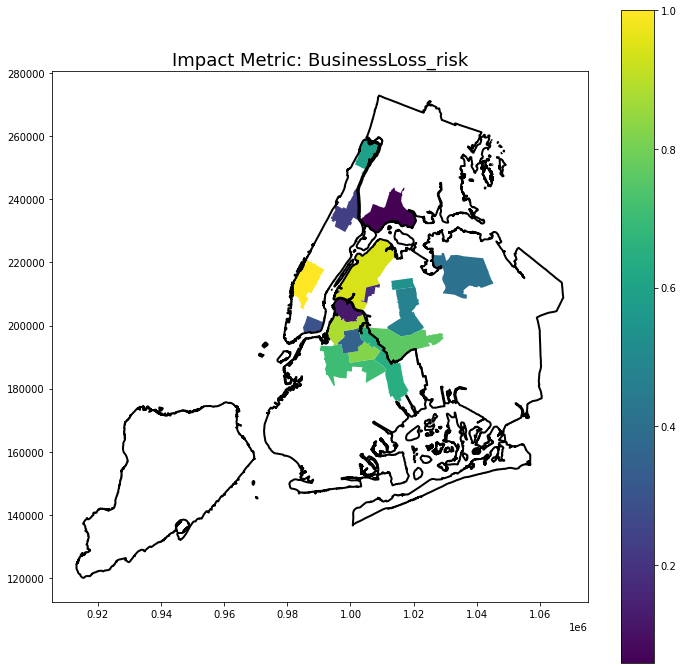

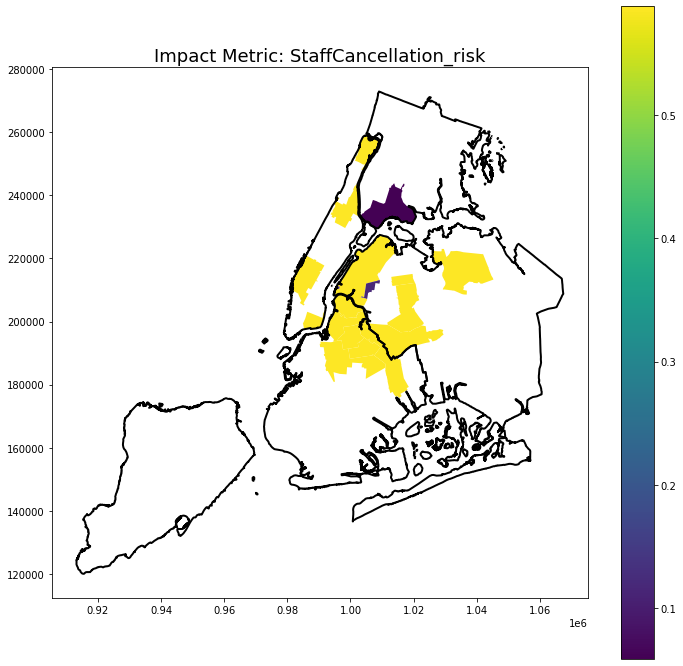

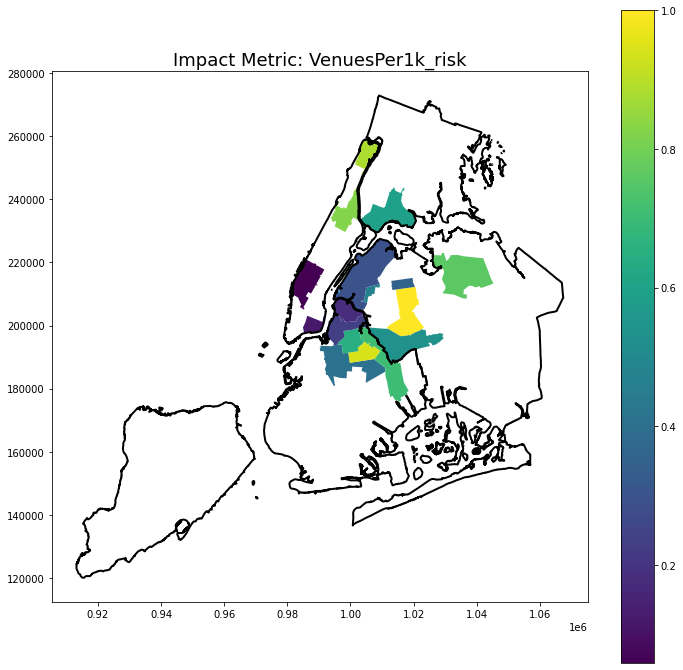

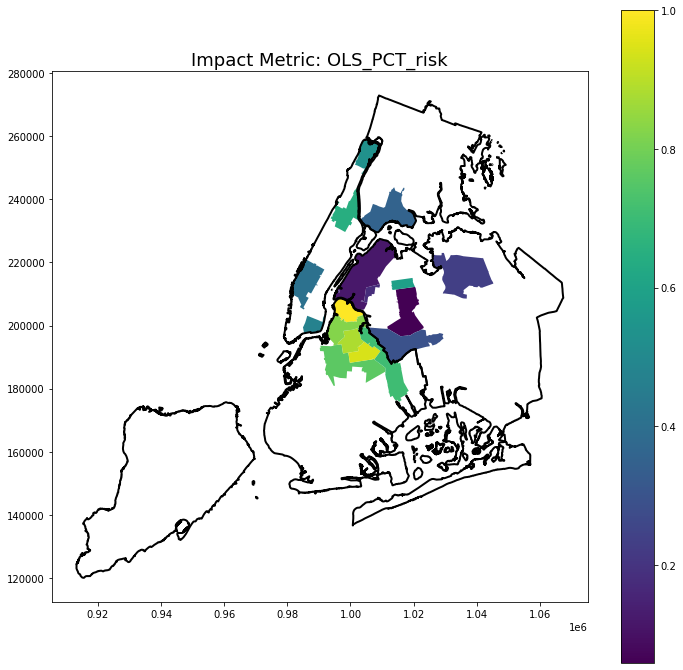

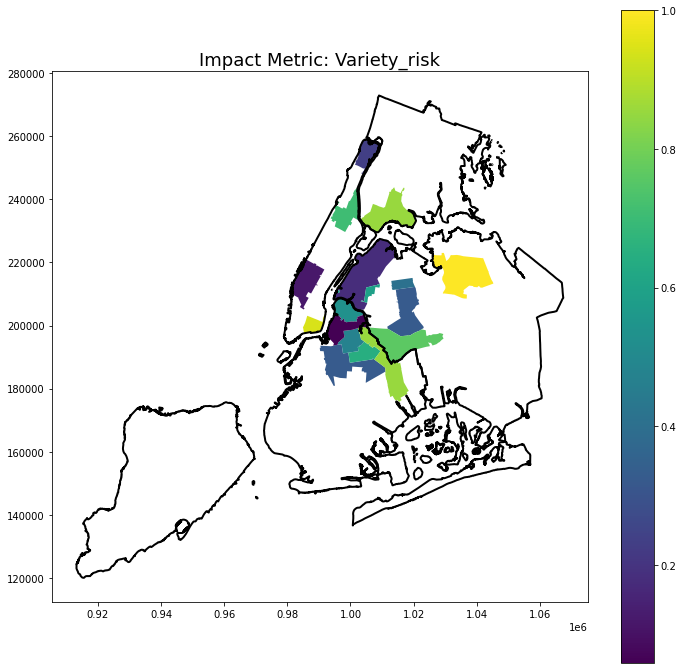

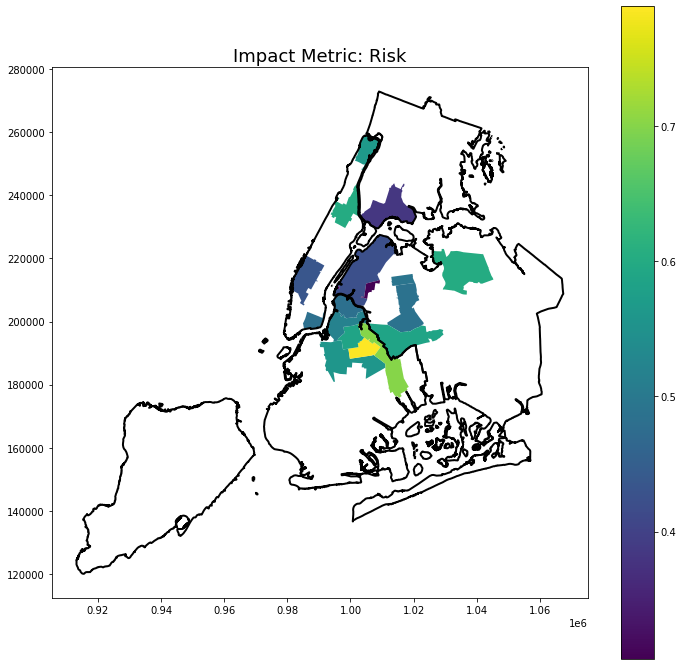

In [42]:
input_metrics = ['BusinessLoss_risk', 'StaffCancellation_risk',
                 'VenuesPer1k_risk', 'OLS_PCT_risk',
                'Variety_risk', 'Risk']
for x in input_metrics:
    f, ax = plt.subplots(figsize=(12, 12))
    ax.set_aspect('equal')
    ax.set_title("Impact Metric: {}".format(x), fontsize=18)
    MetricHeatmaps.plot(axes=ax, column=x, legend = True, cmap='viridis')
    borders.boundary.plot(axes=ax, color=None,edgecolor='k',linewidth = 2)
    plt.savefig('{}.jpg'.format(x))

In [ ]:
# f, ax = plt.subplots(figsize=(12, 12))
# ax.set_aspect('equal')
# ax.set_title("Percentile Ranking", fontsize=18)
# MetricHeatmaps.plot(axes=ax, column='Percentile', legend = True, cmap='viridis')
# borders.boundary.plot(axes=ax, color=None,edgecolor='k',linewidth = 2)
# plt.savefig('PercentileRanking.jpg')

## Create Shp File

In [ ]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

MetricHeatmaps["geometry"] = [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in MetricHeatmaps["geometry"]]

In [ ]:
#MetricHeatmaps.to_file("RiskModel.shp")#, driver="GeoJSON")

## IGNORE HERE

Assigning Binary Risk Values

In [ ]:
# # #Anything above the 75th percentile will be considered risky for BusinessLossMetric, StaffCancellationMetric, & OLS_metric
# # Anything belove the 25th percentile will be considered risky for Venuesper1Kmetric and VarietyMetric
# BusLossRisk = np.quantile(RiskModel['BusinessLossMetric'], .75)
# StaffCancelRisk = np.quantile(RiskModel['StaffCancellationMetric'], .75)
# VenuesRisk = np.quantile(RiskModel['VenuesPer1kMetric'], .75)
# OLSrisk = np.quantile(RiskModel['OLS_PCT_Metric'], .75)
# VarietyRisk = np.quantile(RiskModel['VarietyMetric'], .75)




# #create 5 empty columns to hold the binary risk value,
# RiskModel['Risk1'] = pd.Series() #for businesslossmetric
# RiskModel['Risk2'] = pd.Series() #for staffcancellationmetric
# RiskModel['Risk3'] = pd.Series() #for venuesriskmetric
# RiskModel['Risk4'] = pd.Series() #for OLSriskmetric
# RiskModel['Risk5'] = pd.Series() #for varietyriskmetric

# RiskModel.loc[RiskModel['BusinessLossMetric'] >= BusLossRisk, 'Risk1'] = 1
# RiskModel.loc[RiskModel['BusinessLossMetric'] < BusLossRisk, 'Risk1'] = 0

# RiskModel.loc[RiskModel['StaffCancellationMetric'] >= StaffCancelRisk, 'Risk2'] = 1
# RiskModel.loc[RiskModel['StaffCancellationMetric'] < StaffCancelRisk, 'Risk2'] = 0

# RiskModel.loc[RiskModel['VenuesPer1kMetric'] >= VenuesRisk, 'Risk3'] = 1
# RiskModel.loc[RiskModel['VenuesPer1kMetric'] < VenuesRisk, 'Risk3'] = 0

# RiskModel.loc[RiskModel['OLS_PCT_Metric'] >= OLSrisk, 'Risk4'] = 1
# RiskModel.loc[RiskModel['OLS_PCT_Metric'] < OLSrisk, 'Risk4'] = 0

# RiskModel.loc[RiskModel['VarietyMetric'] >= VarietyRisk, 'Risk5'] = 1
# RiskModel.loc[RiskModel['VarietyMetric'] < VarietyRisk, 'Risk5'] = 0



# risk_list = ['Risk1', 'Risk2', 'Risk3', 'Risk4', 'Risk5']
# RiskModel['TotalRisk'] = RiskModel[risk_list].sum(axis=1)

# RiskModel


# risk_metrics = ['Risk1', 'Risk2', 'Risk3', 'Risk4', 'Risk5', 'TotalRisk']
# for x in risk_metrics:
#     f, ax = plt.subplots(figsize=(12, 12))
#     ax.set_aspect('equal')
#     ax.set_title("Neighborhood Risk: {}".format(x), fontsize=18)
#     MetricHeatmaps.plot(axes=ax, column=x, legend = True, cmap='viridis')
#     borders.boundary.plot(axes=ax, color=None,edgecolor='k',linewidth = 2)
#     plt.savefig('{}.jpg'.format(x))


Building Weights

In [ ]:
# #Find the average of the 2 main risk components (down the col for each col)
# x = Owners_Update['BusinessLossMetric'].mean()
# y = Owners_Update['StaffCancellationMetric'].mean()

# #Weights here are the average of each col divided by the sum of the 2 avgs
# BusLossWeight = x / (x+y)
# StaffCancelWeight = y / (x+y)

# #To calculate the risk, we take each value of BusLoss & staff cancellation
# #multiply by the weight (how much towards risk each value contributes)
# Owners_Update['BusLossNew'] = Owners_Update['BusinessLossMetric']# * BusLossWeight
# Owners_Update['Staff_Cancellation_new'] = Owners_Update['StaffCancellationMetric'] #* StaffCancelWeight

# #Risk adds up the the weighted math (BusLossNew + StaffCancellationNew)
# #This value is on the same scale as the components
# Owners_Update['Risk'] = Owners_Update['Staff_Cancellation_new'] + Owners_Update['BusLossNew']
# Owners_Update.head()

In [ ]:
# #drop nan values from post code
# Owners = Owners[Owners['ZIPCODE_Business'].notna()]

# #filter for the NYC zip codes
# Owners = Owners[(Owners['ZIPCODE_Business'] >= 10001) & (Owners['ZIPCODE_Business'] <= 11697)]

# # Filter the zips we want only

# pertinent_zips = [11102, 11103, 11105, 11106, 11101, 11104, 11109, 11120, 11206, 11211, 11249, 11207, 11221, 11237, 
#                  10026, 10027, 10037, 10030, 10039, 10001, 10011, 10018, 10019, 10020, 10036, 10002, 10034, 10040,
#                  10454, 10455, 10459, 10474, 11205, 11216, 11221, 11233, 11238, 11385, 11386, 10109, 11373,
#                  11379, 11372, 11354, 11355, 11358, 11222]

# Owners = Owners[Owners['ZIPCODE_Business'].isin(pertinent_zips)]

# Owners['NumHoursEmpLost_Perc_median'] = Owners['NumHoursEmpLost_Perc_median']/100
# Owners['BusiIncomeLost_Perc_median'] = Owners['BusiIncomeLost_Perc_median']/100

In [ ]:
# ## Assign each zip to a Neighborhood
# #dictionary to map zips to neighborhoods
# zip_dict ={ 11101:'Astoria/LIC', 11102:'Astoria/LIC', 11103:'Astoria/LIC', 11105:'Astoria/LIC', 11106:'Astoria/LIC', 11104:'LIC',
#            11109:'LIC', 11120:'LIC', 11206:'Williamsburg/Bushwick/Bed-Stuy', 11211:'Williamsburg', 11249:'Williamsburg', 11207:'Bushwick',
#            11221:'Bed-Stuy/Bushwick', 11237:'Bushwick', 10026:'Harlem', 10027:'Harlem', 10037:'Harlem', 10030:'Harlem', 10039:'Harlem',
#            10001:'Chelsea', 10011:'Chelsea', 10018:'Chelsea', 10019:'Chelsea', 10020:'Chelsea', 10036:'Chelsea', 10002:'LES',
#            10034: 'Inwood', 10040: 'Inwood', 10454: 'South Bronx', 10455: 'South Bronx', 10459: 'South Bronx', 10474: 'South Bronx', 
#            11205: 'Bed-Stuy', 11216: 'Bed-Stuy', 11233: 'Bed-Stuy', 11238: 'Bed-Stuy',
#            11385: 'Ridgewood', 11386: 'Ridgewood', 10109: 'Times Square', 
#            11373: 'Elmhurst', 11379: 'Elmhurst', 11372: 'Jackson Heights', 
#            11354: 'Flushing', 11355: 'Flushing', 11358: 'Flushing', 11222: 'Greenpoint'}

# #assign each zip the correct neighborhood name
# Owners['Neighborhood']= Owners['ZIPCODE_Business'].map(zip_dict)

In [ ]:
# risk_features = ['Emp_Avg_median', 'NumHours_Avg_median',
#        'BusiRevenue_Avg_median', 'BusiIncomeLost_Perc_median',
#        'NumHoursEmpLost_Perc_median', 'LostExpenses_Dollars_median',
#        'Staff_Cancellation_median', 'Event_Prod_sum', 'Mgmt_Service_sum',
#        'Nightlife_Est_sum', 'Tech_Service_sum', 'Other_sum',
#        'Total_NumBusinesses']

# Owners['Risk'] = Owners[risk_features].sum(axis=1)
# Owners.head()

In [ ]:
# Bronx = [10453, 10457, 10460, 10458, 10467, 10468, 10451, 10452, 10456, 10454, 10455, 10459, 10474, 
# 10463, 10471, 10466, 10469, 10470, 10475, 10461, 10462,10464, 10465, 10472, 10473]

# Brooklyn = [11212, 11213, 11216, 11233, 11238, 11209, 11214, 11228 ,11204, 11218, 11219, 11230, 11234,
# 11236, 11239, 11223, 11224, 11229, 11235, 11201, 11205, 11215, 11217, 11231, 
# 11203, 11210, 11225, 11226, 11207, 11208, 11211, 11222, 11220, 11232, 11206, 11221, 11237]

# Manhattan = [10026, 10027, 10030, 10037, 10039, 10001, 10011, 10018, 10019, 10020, 10036, 10029, 10035, 
# 10010, 10016, 10017, 10022, 10012, 10013, 10014, 10004, 10005, 10006, 10007, 10038, 10280, 10002, 10003, 10009,
# 10021, 10028, 10044, 10065, 10075, 10128, 10023, 10024, 10025, 10031, 10032, 10033, 10034, 10040]

# Queens = [11361, 11362, 11363, 11364, 11354, 11355, 11356, 11357, 11358, 11359, 11360, 11365, 11366, 11367, 
# 11412, 11423, 11432, 11433, 11434, 11435, 11436, 11101, 11102, 11103, 11104, 11105, 11106, 11374, 11375, 11379, 11385,
# 11691, 11692, 11693, 11694, 11695, 11697, 11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428, 11429,
# 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421, 11368, 11369, 11370, 11372, 11373, 11377, 11378]

# Staten_I = [10302, 10303, 10310, 10306, 10307, 10308, 10309, 10312, 10301, 10304, 10305, 10314]

## Manhattan Staff Wrangling

In [ ]:
MH = MH[MH['ZIPCODE_Home'].notna()]
MH['ZIPCODE_Home'] = MH['ZIPCODE_Home'].astype(int)
m1 = MH[MH['ZIPCODE_Home'].isin([10026, 10027, 10030, 10037, 10039, 10001, 10011, 10018, 10019, 10020, 10036, 10029, 10035, 
10010, 10016, 10017, 10022, 10012, 10013, 10014, 10004, 10005, 10006, 10007, 10038, 10280, 10002, 10003, 10009,
10021, 10028, 10044, 10065, 10075, 10128, 10023, 10024, 10025, 10031, 10032, 10033, 10034, 10040])]
m1['Boro_Overlap']='same'
m2 = MH[~MH['ZIPCODE_Home'].isin([10026, 10027, 10030, 10037, 10039, 10001, 10011, 10018, 10019, 10020, 10036, 10029, 10035, 
10010, 10016, 10017, 10022, 10012, 10013, 10014, 10004, 10005, 10006, 10007, 10038, 10280, 10002, 10003, 10009,
10021, 10028, 10044, 10065, 10075, 10128, 10023, 10024, 10025, 10031, 10032, 10033, 10034, 10040])]
m2['Boro_Overlap']='different'
final_concat = [m1, m2]
MH = pd.concat(final_concat)

In [ ]:
# Total Number of People that live in MH / Total Number of People that don't live in MH
M_Ratio = len(m1)/len(m2)
MH['Ratio'] = M_Ratio

In [ ]:
MH.head()

## Brooklyn Staff Wrangling

In [ ]:
BK = BK[BK['ZIPCODE_Home'].notna()]
BK['ZIPCODE_Home'] = BK['ZIPCODE_Home'].astype(int)
b1 = BK[BK['ZIPCODE_Home'].isin([11212, 11213, 11216, 11233, 11238, 11209, 11214, 11228 ,11204, 11218, 11219, 11230, 11234,
11236, 11239, 11223, 11224, 11229, 11235, 11201, 11205, 11215, 11217, 11231, 
11203, 11210, 11225, 11226, 11207, 11208, 11211, 11222, 11220, 11232, 11206, 11221, 11237])]
b1['Boro_Overlap']='same'
b2 = BK[~BK['ZIPCODE_Home'].isin([11212, 11213, 11216, 11233, 11238, 11209, 11214, 11228 ,11204, 11218, 11219, 11230, 11234,
11236, 11239, 11223, 11224, 11229, 11235, 11201, 11205, 11215, 11217, 11231, 
11203, 11210, 11225, 11226, 11207, 11208, 11211, 11222, 11220, 11232, 11206, 11221, 11237])]
b2['Boro_Overlap']='different'
b_concat = [b1, b2]
BK = pd.concat(b_concat)

In [ ]:
# Total Number of People that live in MH / Total Number of People that don't live in MH
B_Ratio = len(b1)/len(b2)
BK['Ratio'] = (B_Ratio)

In [ ]:
BK.head()

## Bronx Staff Wrangling

In [ ]:
BX = BX[BX['ZIPCODE_Home'].notna()]
BX['ZIPCODE_Home'] = BX['ZIPCODE_Home'].astype(int)
bx1 = BX[BX['ZIPCODE_Home'].isin([10453, 10457, 10460, 10458, 10467, 10468, 10451, 10452, 10456, 10454, 10455, 10459, 10474, 
10463, 10471, 10466, 10469, 10470, 10475, 10461, 10462,10464, 10465, 10472, 10473])]
bx1['Boro_Overlap']='same'
bx2 = BX[~BX['ZIPCODE_Home'].isin([10453, 10457, 10460, 10458, 10467, 10468, 10451, 10452, 10456, 10454, 10455, 10459, 10474, 
10463, 10471, 10466, 10469, 10470, 10475, 10461, 10462,10464, 10465, 10472, 10473])]
bx2['Boro_Overlap']='different'
bx_concat = [bx1, bx2]
BX = pd.concat(bx_concat)
BX.Boro_Overlap.unique()

In [ ]:
# Total Number of People that live in MH / Total Number of People that don't live in MH
BX_Ratio = len(bx1)/len(bx2)
BX['Ratio'] = (BX_Ratio)

## Queens Staff Wrangling

In [ ]:
Q = Q[Q['ZIPCODE_Home'].notna()]
Q['ZIPCODE_Home'] = Q['ZIPCODE_Home'].astype(int)
q1 = Q[Q['ZIPCODE_Home'].isin([11361, 11362, 11363, 11364, 11354, 11355, 11356, 11357, 11358, 11359, 11360, 11365, 11366, 11367, 
11412, 11423, 11432, 11433, 11434, 11435, 11436, 11101, 11102, 11103, 11104, 11105, 11106, 11374, 11375, 11379, 11385,
11691, 11692, 11693, 11694, 11695, 11697, 11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428, 11429,
11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421, 11368, 11369, 11370, 11372, 11373, 11377, 11378])]
q1['Boro_Overlap']='same'
q2 = Q[~Q['ZIPCODE_Home'].isin([11361, 11362, 11363, 11364, 11354, 11355, 11356, 11357, 11358, 11359, 11360, 11365, 11366, 11367, 
11412, 11423, 11432, 11433, 11434, 11435, 11436, 11101, 11102, 11103, 11104, 11105, 11106, 11374, 11375, 11379, 11385,
11691, 11692, 11693, 11694, 11695, 11697, 11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428, 11429,
11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421, 11368, 11369, 11370, 11372, 11373, 11377, 11378])]
q2['Boro_Overlap']='different'
q_concat = [q1, q2]
Q = pd.concat(q_concat)
Q.Boro_Overlap.unique()

In [ ]:
# Total Number of People that live in MH / Total Number of People that don't live in MH
Q_Ratio = len(q1)/len(q2)
Q['Ratio'] = (Q_Ratio)

## Staten Island Wrangling

In [ ]:
SI = SI[SI['ZIPCODE_Home'].notna()]
SI['ZIPCODE_Home'] = SI['ZIPCODE_Home'].astype(int)
si1 = SI[SI['ZIPCODE_Home'].isin([10302, 10303, 10310, 10306, 10307, 10308, 10309, 10312, 10301, 10304, 10305, 10314])]
si1['Boro_Overlap']='same'
si2 = SI[~SI['ZIPCODE_Home'].isin([10302, 10303, 10310, 10306, 10307, 10308, 10309, 10312, 10301, 10304, 10305, 10314])]
si2['Boro_Overlap']='different'
si_concat = [si1, si2]
SI = pd.concat(si_concat)
SI.Boro_Overlap.unique()

In [ ]:
# Total Number of People that live in MH / Total Number of People that don't live in MH
SI_Ratio = len(si1)/len(si2)
SI['Ratio'] = (SI_Ratio)

## Final Staff Analysis

In [ ]:
frames = [MH, BK, BX, SI, Q]
all_staff = pd.concat(frames)

In [ ]:
all_staff.head()

In [ ]:
x = all_staff['Work BORO'].unique()
y = all_staff['Ratio'].unique()

In [ ]:
z = pd.DataFrame()
z['boro_name'] = x
z['Ratio'] = y

In [ ]:
z.head()

In [ ]:
staff_map = borders.merge(z, on='boro_name')

In [ ]:
f, ax = plt.subplots(1, figsize=(12, 12))
ax.set_title("EDA for Culture", fontsize=18)
staff_map.plot(axes=ax, column='Ratio', legend = True, cmap='viridis')
#borders.boundary.plot(axes=ax, color=None,edgecolor='k',linewidth = 2)